In [45]:
import warnings
import numpy as np
import pandas as pd
import statistics
import matplotlib.patches as mpatches

from glob import glob
from tqdm import tqdm

from skimage import (
    filters, 
    measure,
    morphology, 
    img_as_ubyte,
    img_as_bool,
    io, 
    color, 
    draw)

from skimage.io import imsave, imread, imread_collection

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.transform import resize

from scipy import ndimage as ndi
from scipy import optimize
from skimage.color import label2rgb, rgb2gray
from commons import rule_of_three_percent_pixels, check_colision_border

In [2]:
warnings.filterwarnings('ignore')

In [53]:
def plot(arr_images=[], grid=(1, 1), cmap="inferno"):

    fig = plt.figure(figsize=(20, 10))

    grid = ImageGrid(fig, 111, nrows_ncols=grid,  axes_pad=0.1)

    for ax, img in zip(grid, arr_images):
        ax.imshow(img, cmap)
        ax.axis('off')

    plt.show()  
    
    
def auto_invert_image_mask(arr):
    img = arr.copy()

    if statistics.mode(img.flatten()):
        img = np.invert(img)

    return img

def find_bighest_cluster_area(clusters):
    regions = measure.regionprops(clusters)

    all_areas = map(lambda item: item.area, regions)

    return max(all_areas)

def find_bighest_cluster(img):

    clusters = auto_invert_image_mask(img)

    clusters = measure.label(clusters, background=0)

    cluster_size = find_bighest_cluster_area(clusters)

    return morphology.remove_small_objects(clusters,
                                         min_size=(cluster_size - 1),
                                         connectivity=8)

def rescale_image(image, scale=255):
    return (image * scale).astype('uint8')
   
def binarize_image(image):
    return image > filters.threshold_otsu(image)

def get_image_area(image):
    return find_bighest_cluster_area(measure.label(image, background=0))

def generate_elipses(img):
    # https://forum.image.sc/t/simplify-complex-region-for-elliptical-hough-transform/63979/3
    
    image = img_as_bool(img)
    image = morphology.binary_closing(image, 
                                      footprint=morphology.disk(5))
    
    image = ndi.binary_fill_holes(image)
    props, *_ = measure.regionprops(measure.label(image))
    
    y0, x0 = props.centroid
    rotation = props.orientation
    r_radius = props.major_axis_length / 2
    c_radius = props.minor_axis_length / 2
    
    def cost(params):
        x0, y0, r_radius, c_radius, rotation = params
        
        coords = draw.ellipse(y0, 
                              x0,
                              r_radius, 
                              c_radius, 
                              rotation=rotation, 
                              shape=image.shape)
        
        template = np.zeros_like(image)
        template[coords] = 1
        positive_mask = (template == 1)

        true_positive = np.sum(image[positive_mask])
        false_positive = np.sum(template[positive_mask] != image[positive_mask])
        
        # false_negative = np.sum(template[~positive_mask] != image[~positive_mask])
        # f1 = true_positive / (true_positive + 0.5 * (false_positive + false_negative))
        # score = -f1

        score = -(true_positive - 5 * false_positive)

        return score

    # Comment out this line to see what the fit looks like without optimization
    x0, y0, r_radius, c_radius, rotation = optimize.fmin(cost, 
                                                         (x0,
                                                          y0,
                                                          r_radius, 
                                                          c_radius, 
                                                          rotation))

    rr, cc = draw.ellipse(y0,
                          x0, 
                          r_radius,
                          c_radius, 
                          rotation=rotation, 
                          shape=image.shape)
    
    image_rgb = color.gray2rgb(image.astype(float)) * 0.5
    image_rgb[rr, cc] += [0.3, 0.25, 0.4]
    
    return image_rgb

In [4]:
image = rescale_image(imread("data_rgb/001/imagens_rgb/51.png", as_gray=True))

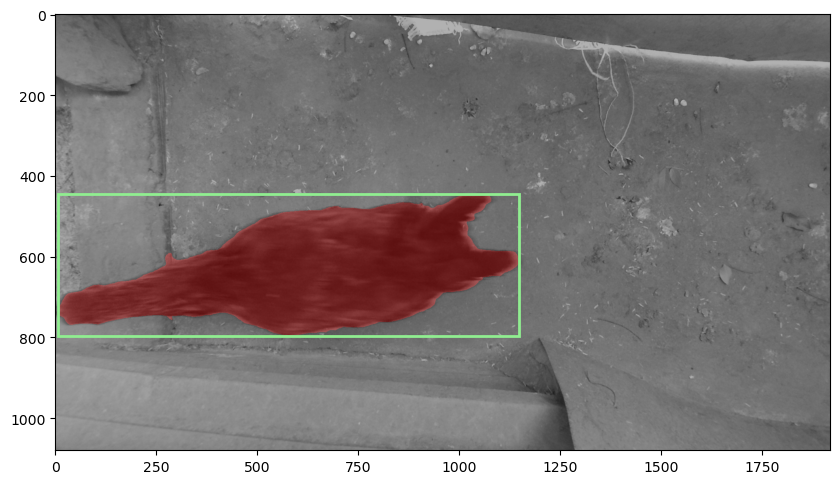

In [5]:
tresh = image < filters.threshold_local(image * 2, block_size=35, offset=10)
mask = find_bighest_cluster(auto_invert_image_mask(tresh))
bw = morphology.closing(mask, morphology.square(5))
bw = ndi.binary_fill_holes(bw)
label_image = measure.label(bw)

image_label_overlay = label2rgb(label_image,
                                image=image, 
                                bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in measure.regionprops(label_image):
    if region.area >= 500:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), 
                                  maxc - minc, 
                                  maxr - minr, 
                                  fill=False, 
                                  edgecolor='lightgreen', 
                                  linewidth=2)
        ax.add_patch(rect)

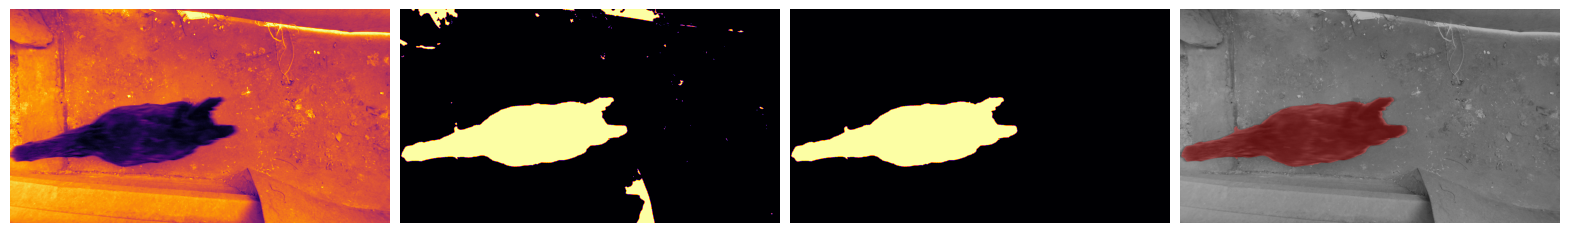

In [6]:
plot([image, tresh, mask, image_label_overlay], (1, 4))

In [7]:
masks= []

for path in glob("data_rgb/001/**/*"):
    
    image_gray = rescale_image(imread(path, as_gray=True))
    image_pixel = auto_invert_image_mask(binarize_image(image_gray))
    
    if rule_of_three_percent_pixels(image_pixel)['false_pixels'] > 80: #%

        tresh = image_gray < filters.threshold_local(image_gray * 2, block_size=35, offset=10) 
        mask = find_bighest_cluster(auto_invert_image_mask(tresh))
        bw = morphology.closing(mask, morphology.square(5))
        
        masks.append(ndi.binary_fill_holes(bw))

In [57]:
# Ignorandoalgumas imagens ruins através de patterns

# all_size = list(map(get_image_area, masks))
# threshold = int(np.mean(all_size))
# max_ = max(all_size)

# for index, image in enumerate(tqdm(masks)):
#     current_size = get_image_area(image)
    
#     x_axis, *_ = image.shape
    
#     if current_size >= threshold and current_size < max_ and not image[x_axis - 1: x_axis, ].sum():
#         plot([image])

Optimization terminated successfully.
         Current function value: -156908.000000
         Iterations: 105
         Function evaluations: 238


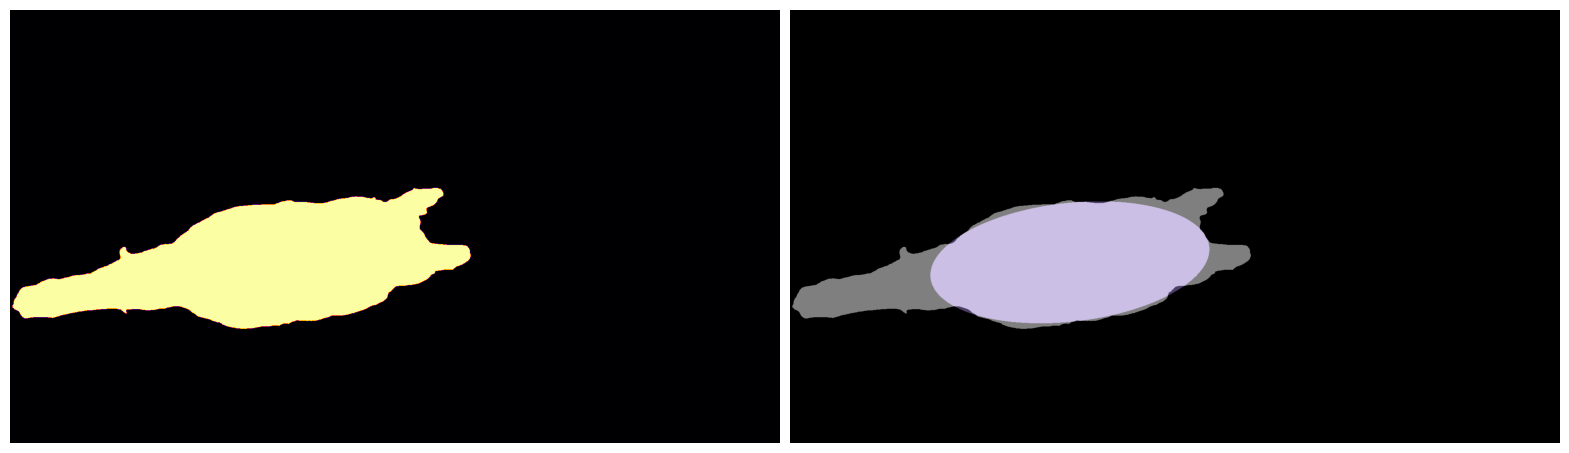

Optimization terminated successfully.
         Current function value: -185344.000000
         Iterations: 135
         Function evaluations: 286


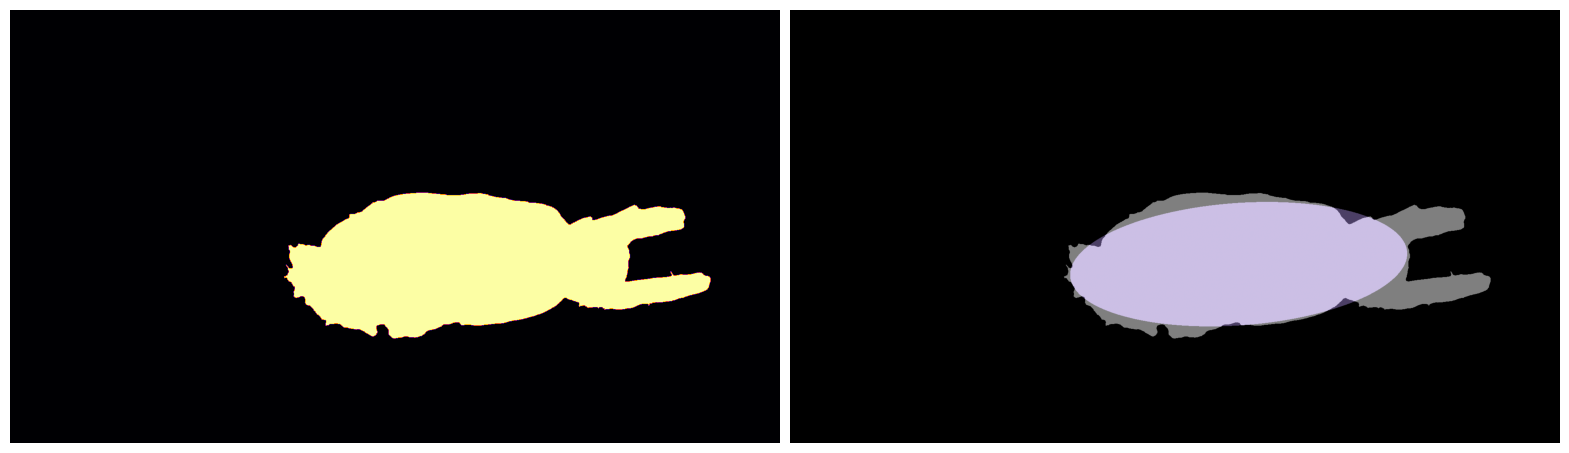

Optimization terminated successfully.
         Current function value: -187029.000000
         Iterations: 126
         Function evaluations: 267


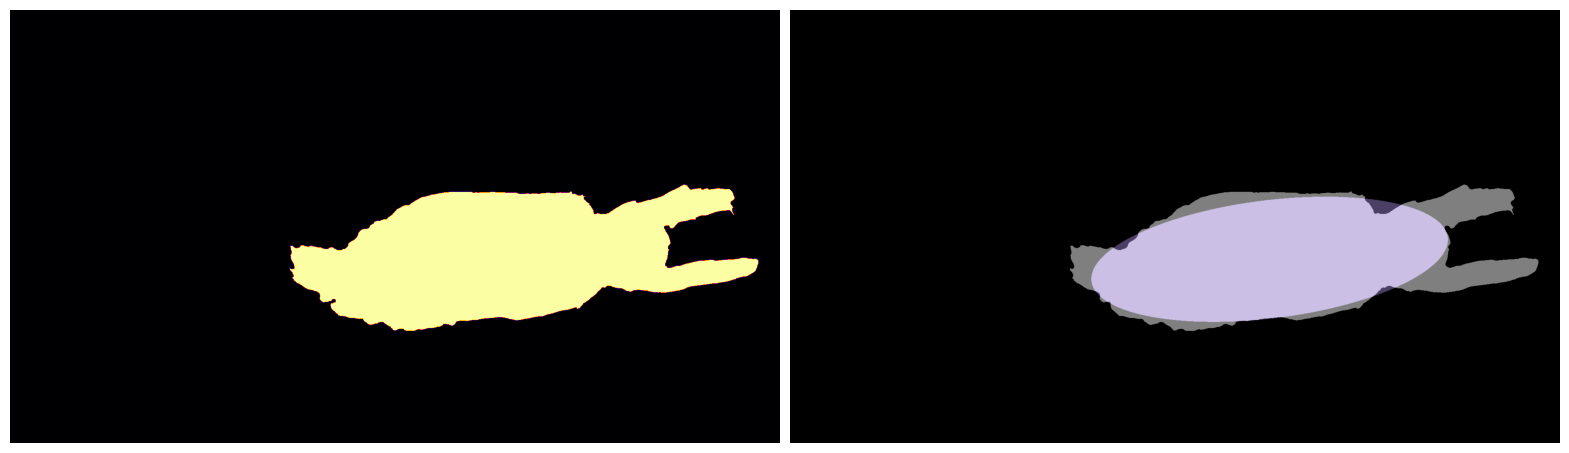

Optimization terminated successfully.
         Current function value: -121811.000000
         Iterations: 119
         Function evaluations: 274


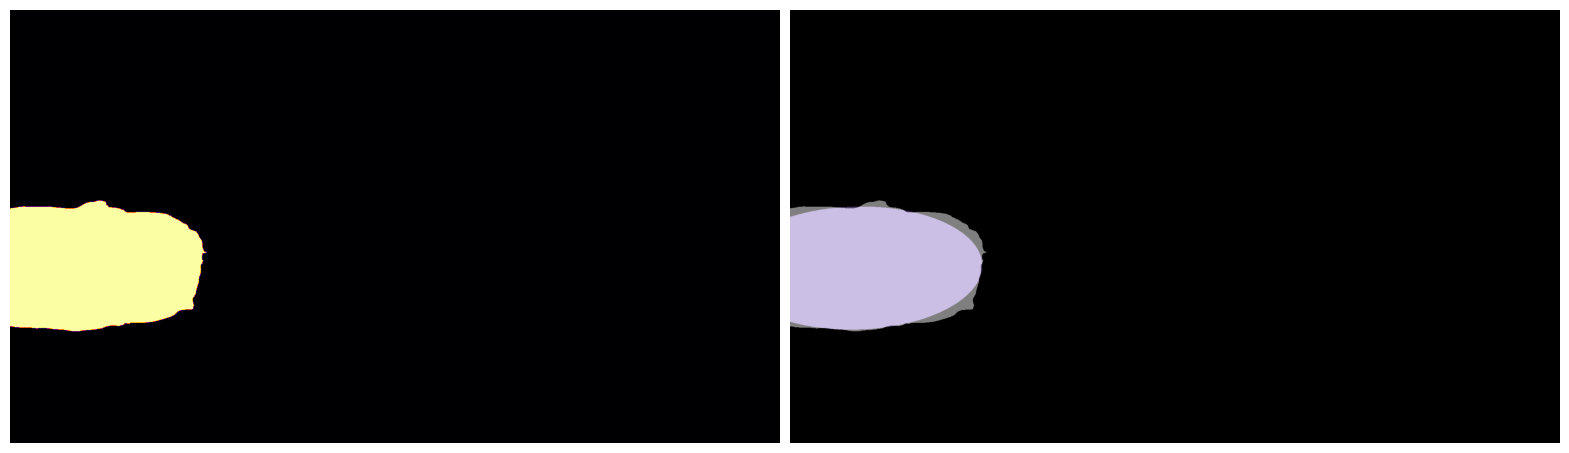

Optimization terminated successfully.
         Current function value: -141642.000000
         Iterations: 114
         Function evaluations: 253


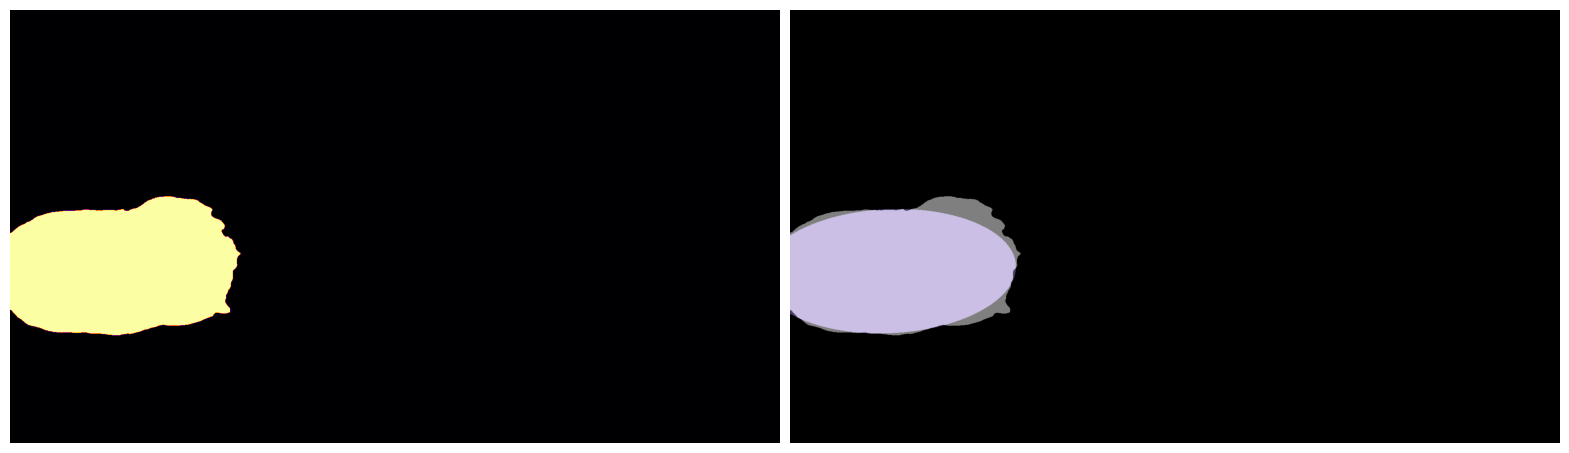

Optimization terminated successfully.
         Current function value: -206536.000000
         Iterations: 177
         Function evaluations: 350


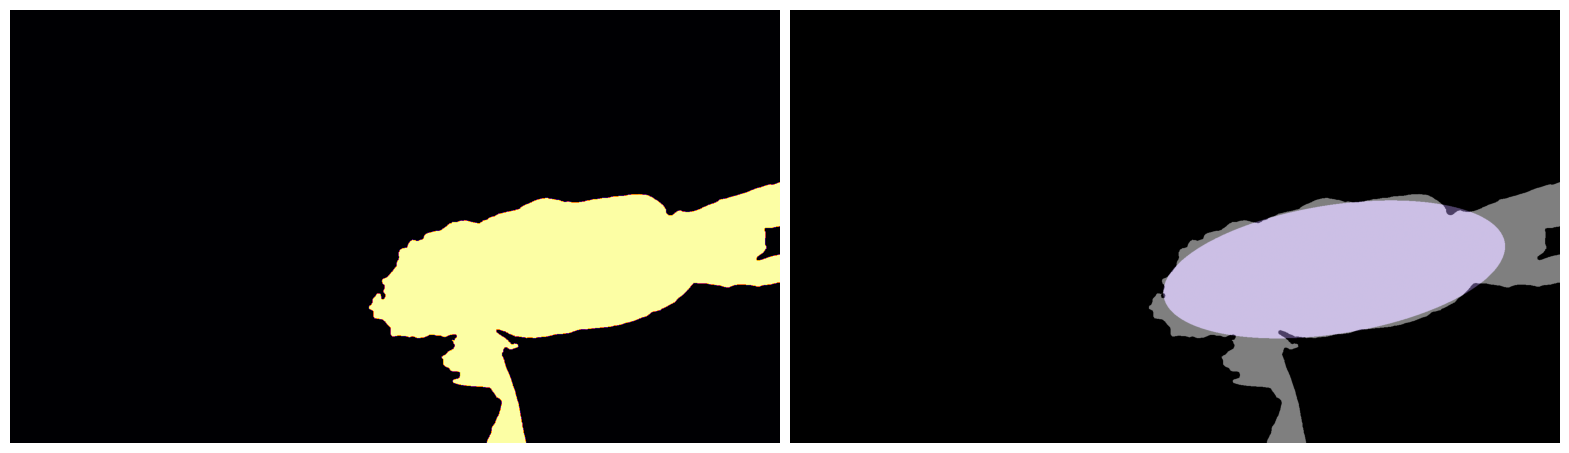

Optimization terminated successfully.
         Current function value: -150644.000000
         Iterations: 108
         Function evaluations: 239


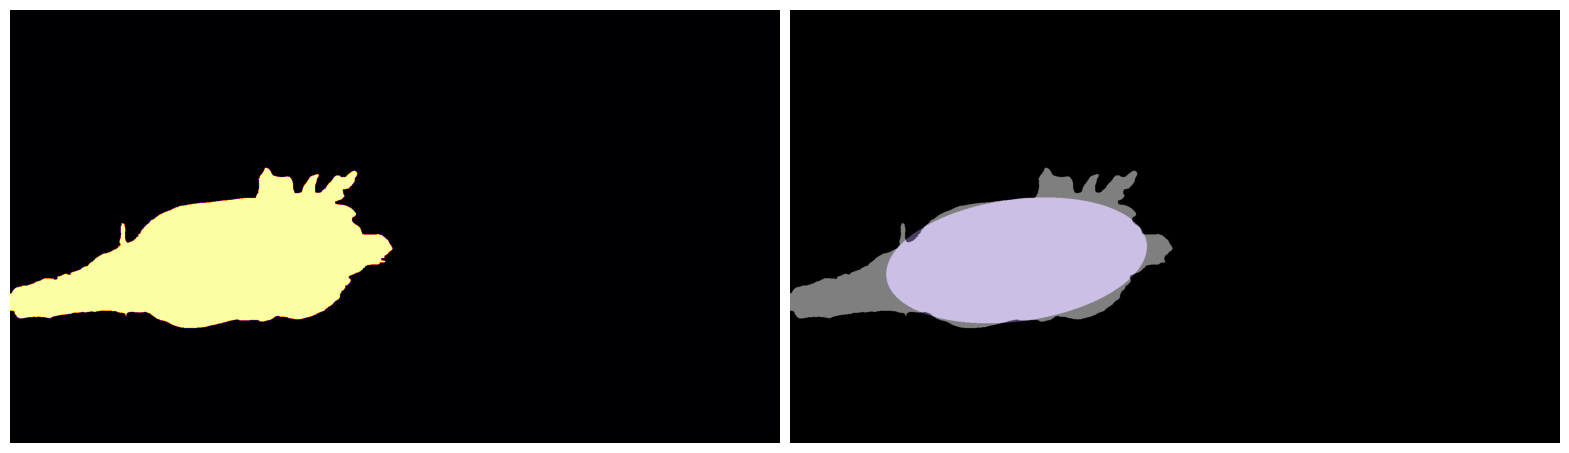

Optimization terminated successfully.
         Current function value: -172376.000000
         Iterations: 128
         Function evaluations: 263


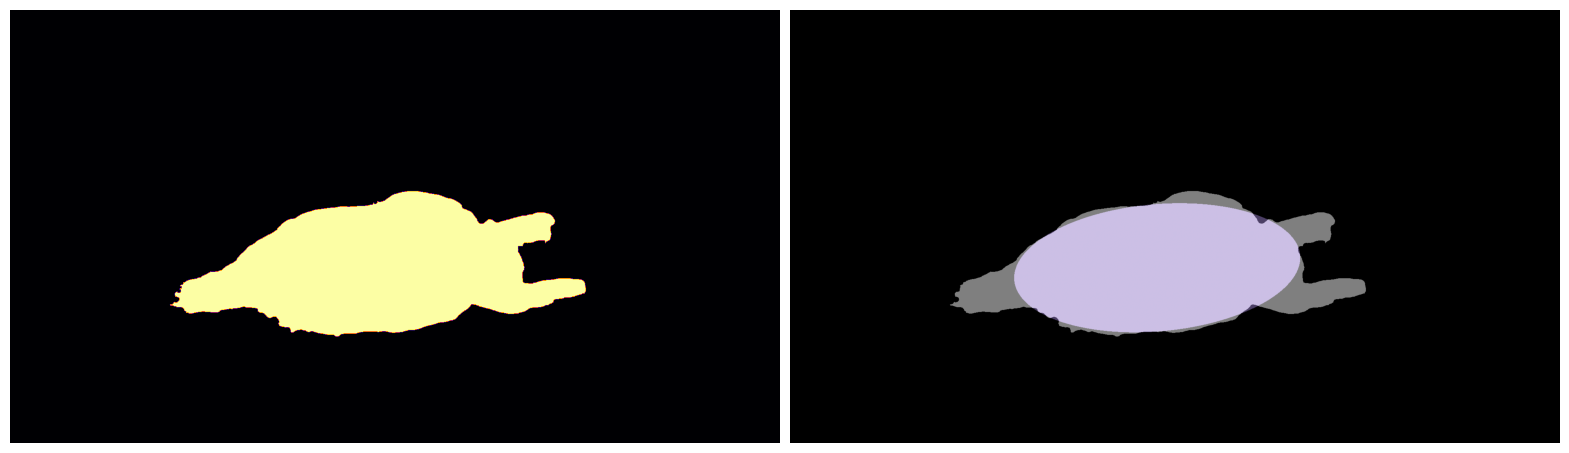

Optimization terminated successfully.
         Current function value: -177244.000000
         Iterations: 148
         Function evaluations: 300


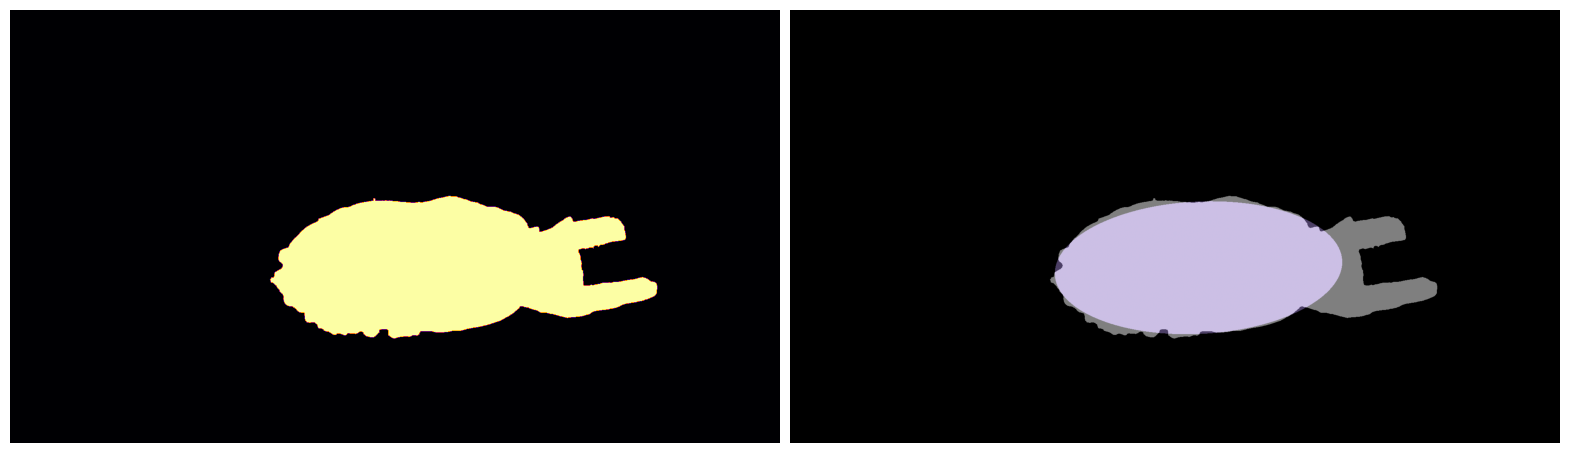

Optimization terminated successfully.
         Current function value: -149130.000000
         Iterations: 102
         Function evaluations: 223


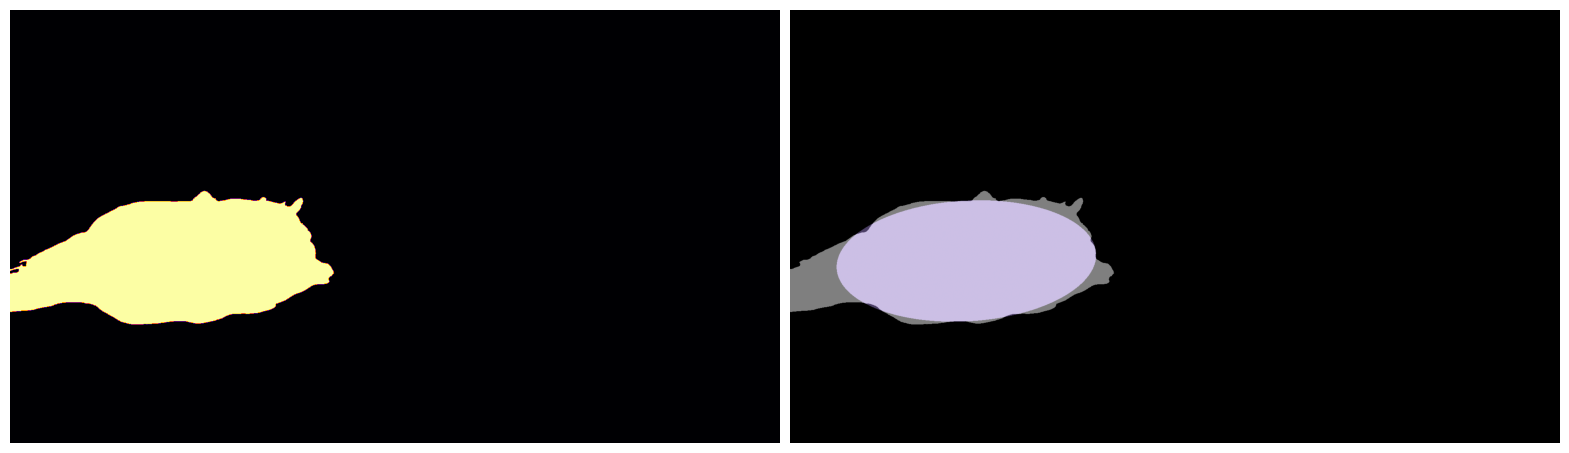

Optimization terminated successfully.
         Current function value: -60438.000000
         Iterations: 152
         Function evaluations: 301


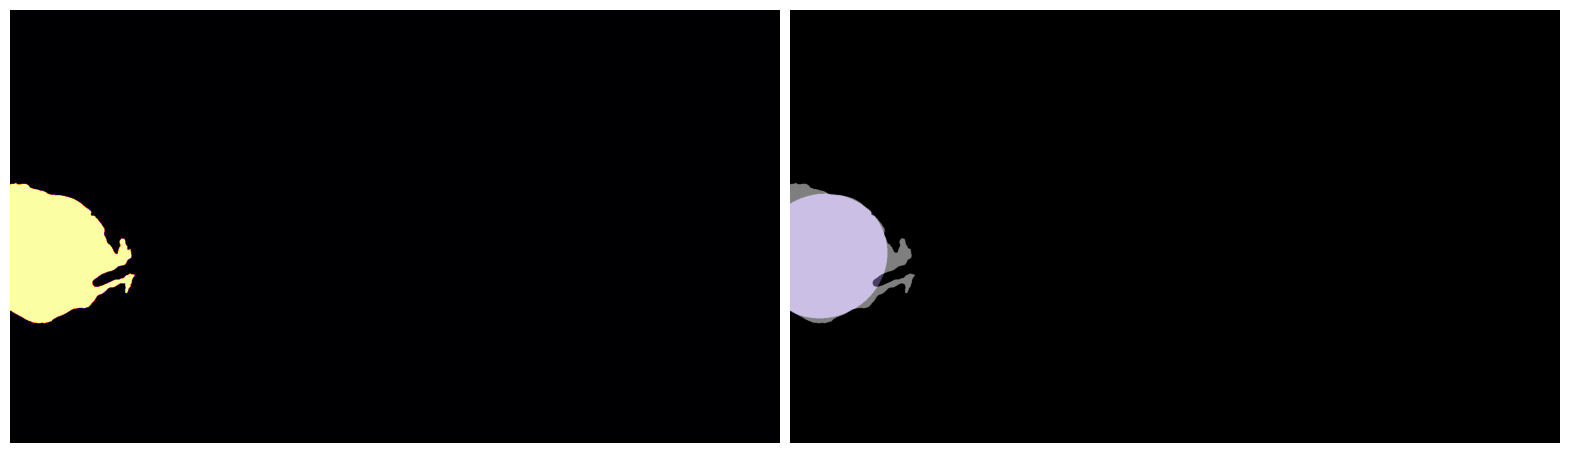

Optimization terminated successfully.
         Current function value: -166609.000000
         Iterations: 102
         Function evaluations: 239


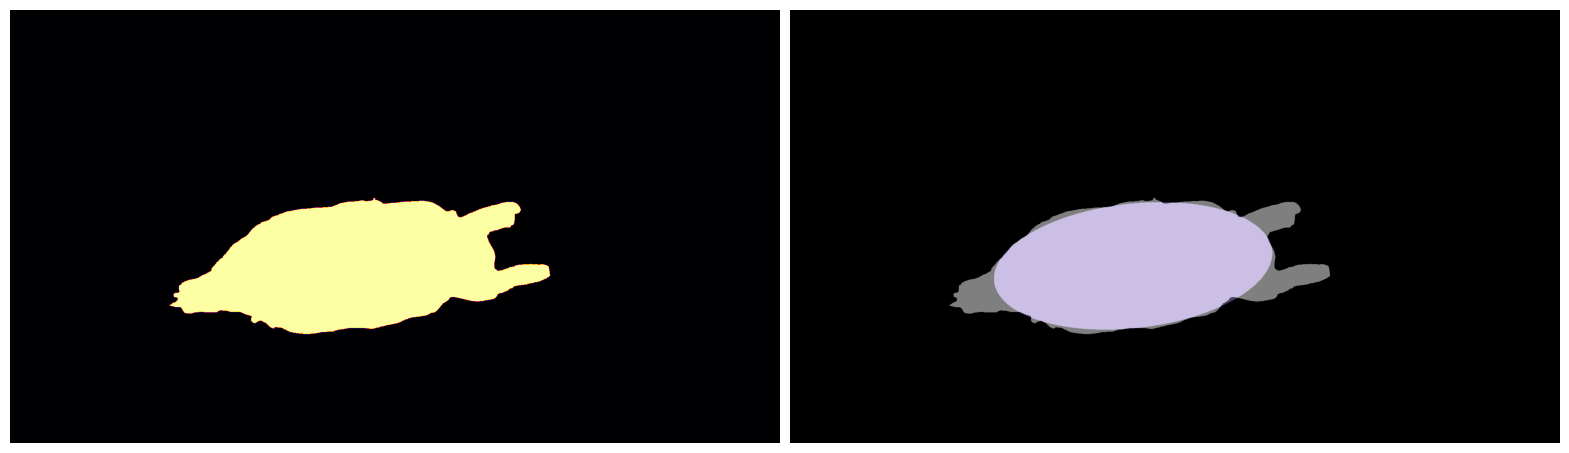

Optimization terminated successfully.
         Current function value: -47690.000000
         Iterations: 120
         Function evaluations: 266


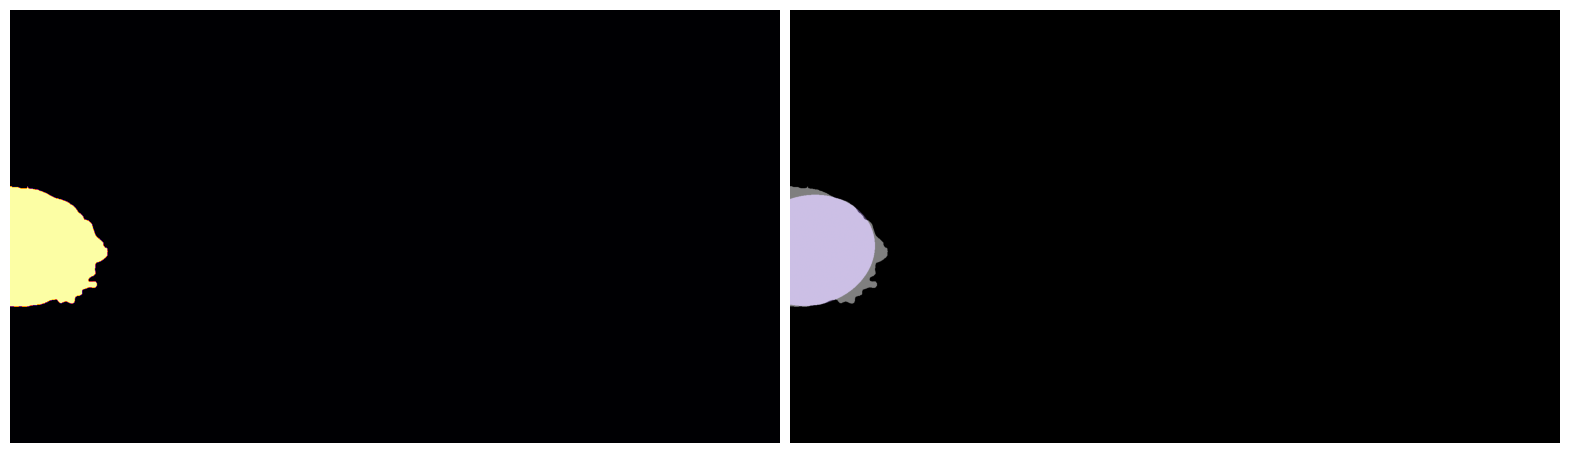

Optimization terminated successfully.
         Current function value: -35359.000000
         Iterations: 99
         Function evaluations: 230


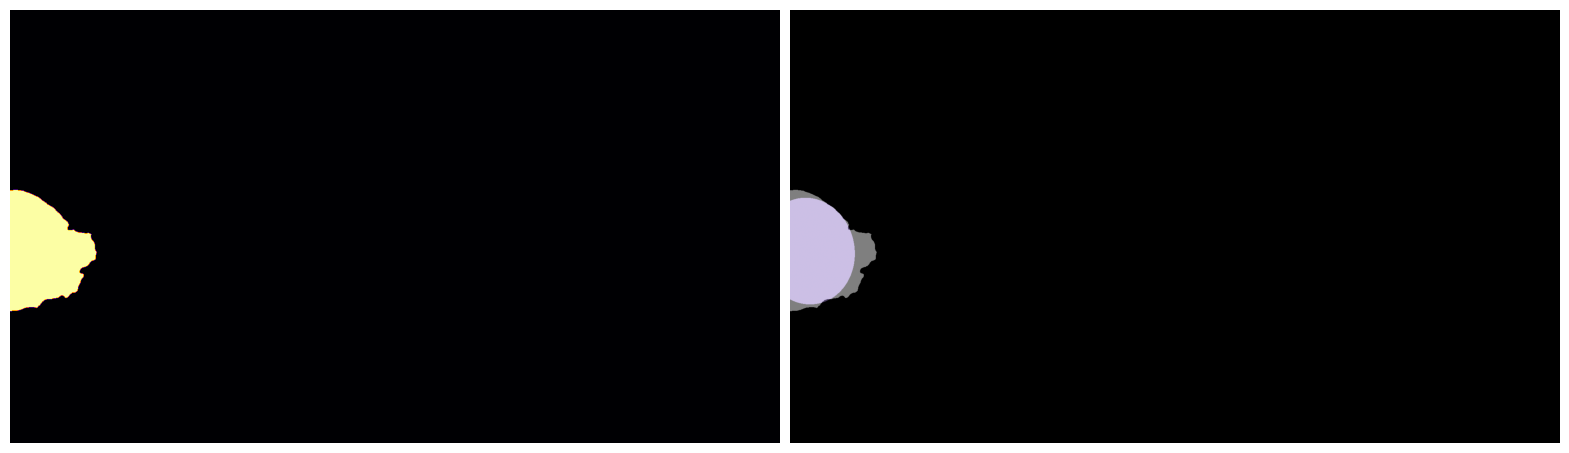

Optimization terminated successfully.
         Current function value: -230624.000000
         Iterations: 121
         Function evaluations: 261


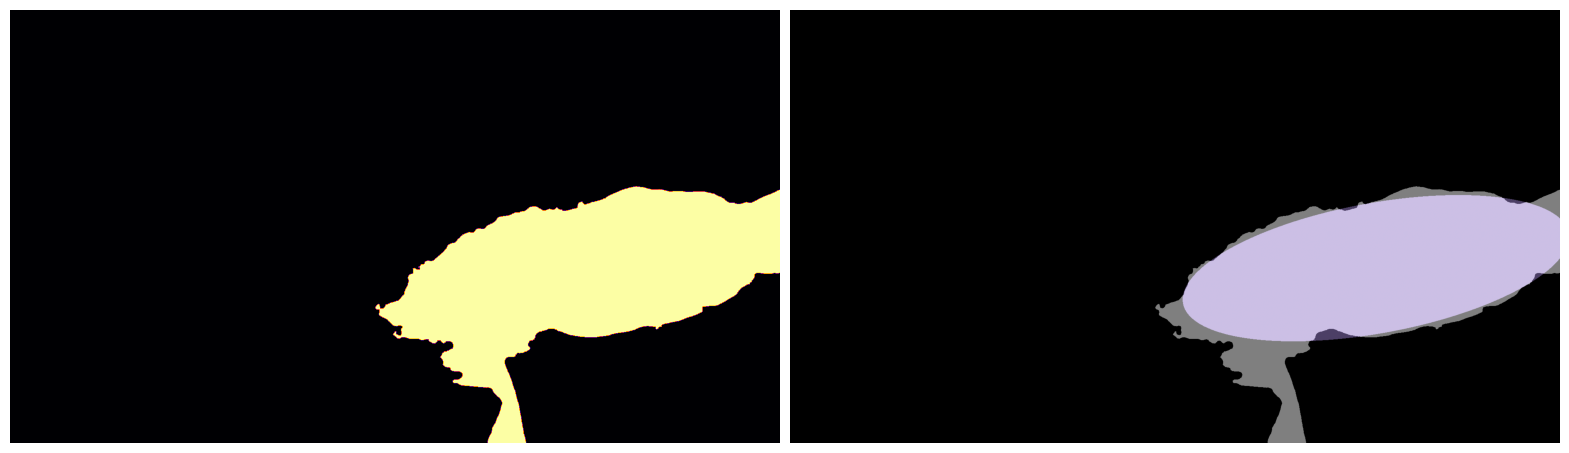

Optimization terminated successfully.
         Current function value: -146735.000000
         Iterations: 103
         Function evaluations: 229


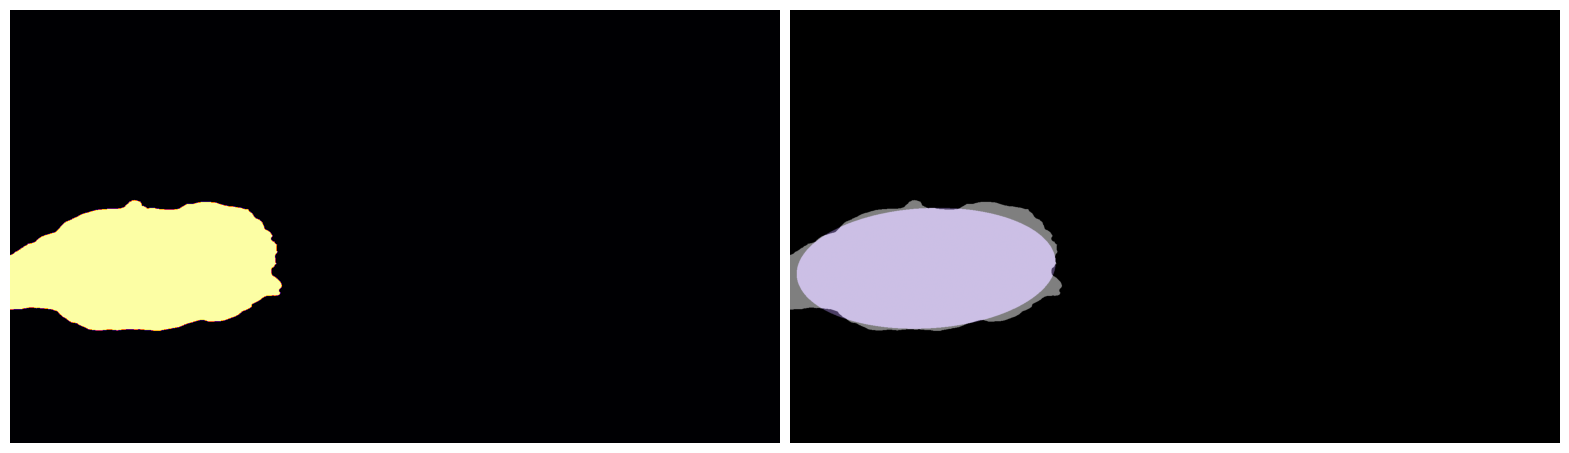

Optimization terminated successfully.
         Current function value: -180976.000000
         Iterations: 126
         Function evaluations: 271


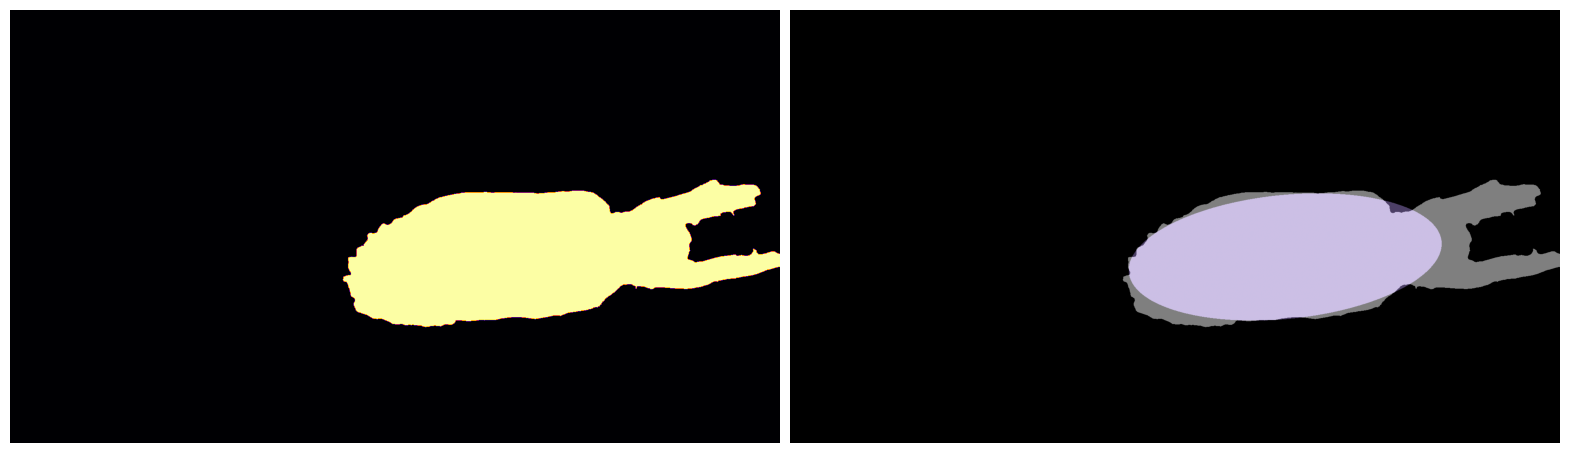

Optimization terminated successfully.
         Current function value: -188730.000000
         Iterations: 121
         Function evaluations: 253


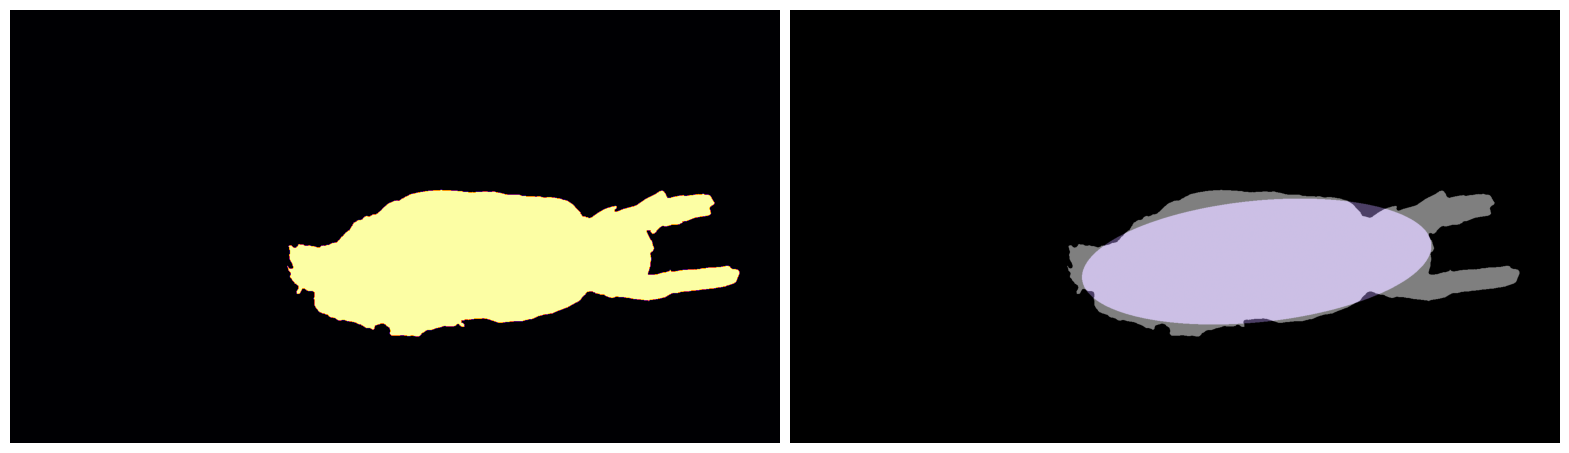

Optimization terminated successfully.
         Current function value: -41913.000000
         Iterations: 105
         Function evaluations: 248


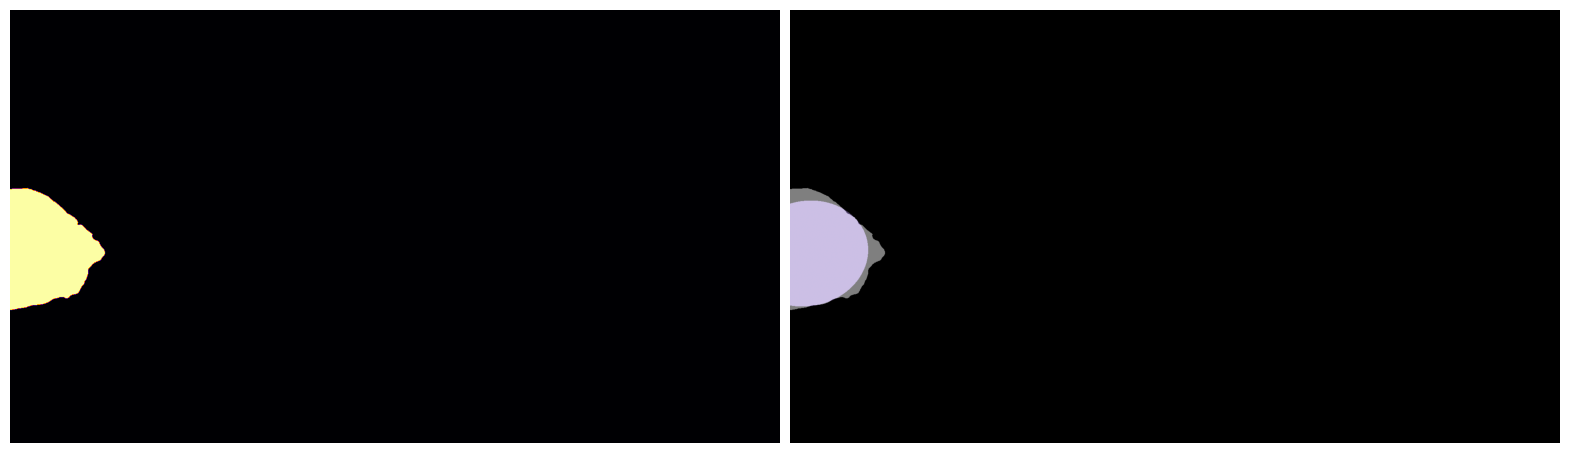

Optimization terminated successfully.
         Current function value: -223264.000000
         Iterations: 157
         Function evaluations: 324


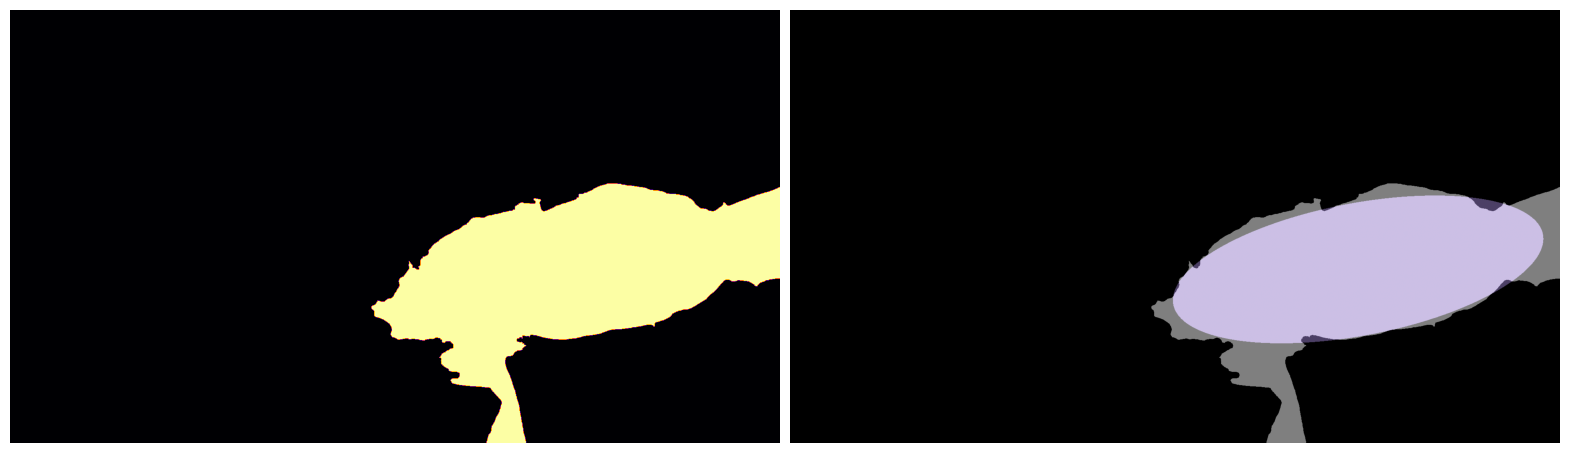

Optimization terminated successfully.
         Current function value: -198786.000000
         Iterations: 181
         Function evaluations: 352


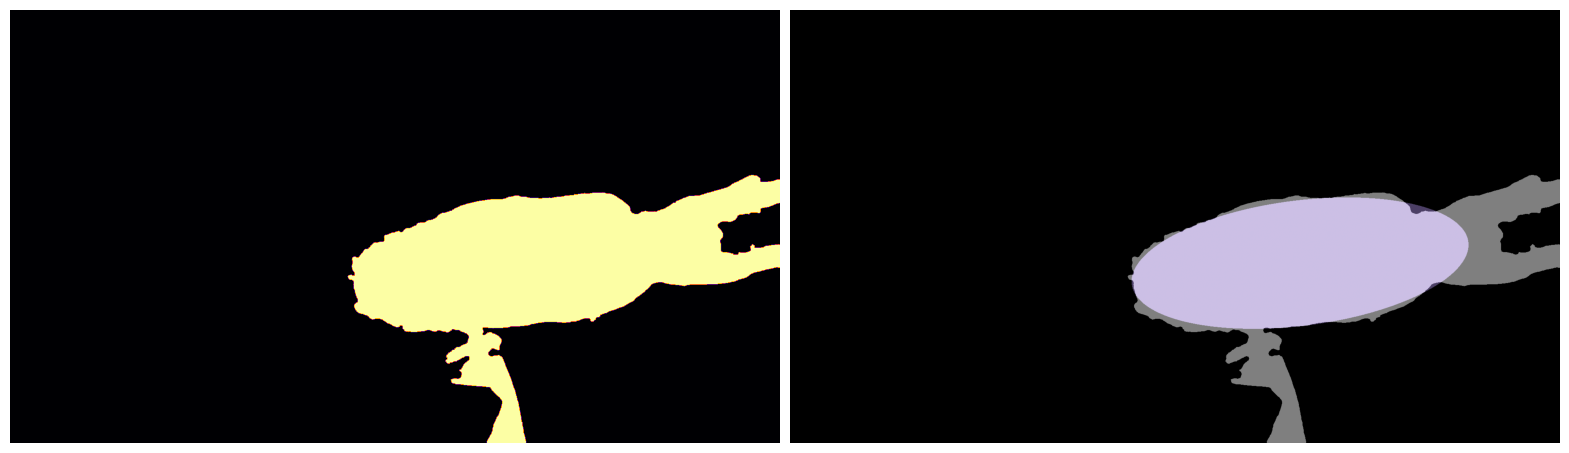

Optimization terminated successfully.
         Current function value: -183304.000000
         Iterations: 184
         Function evaluations: 359


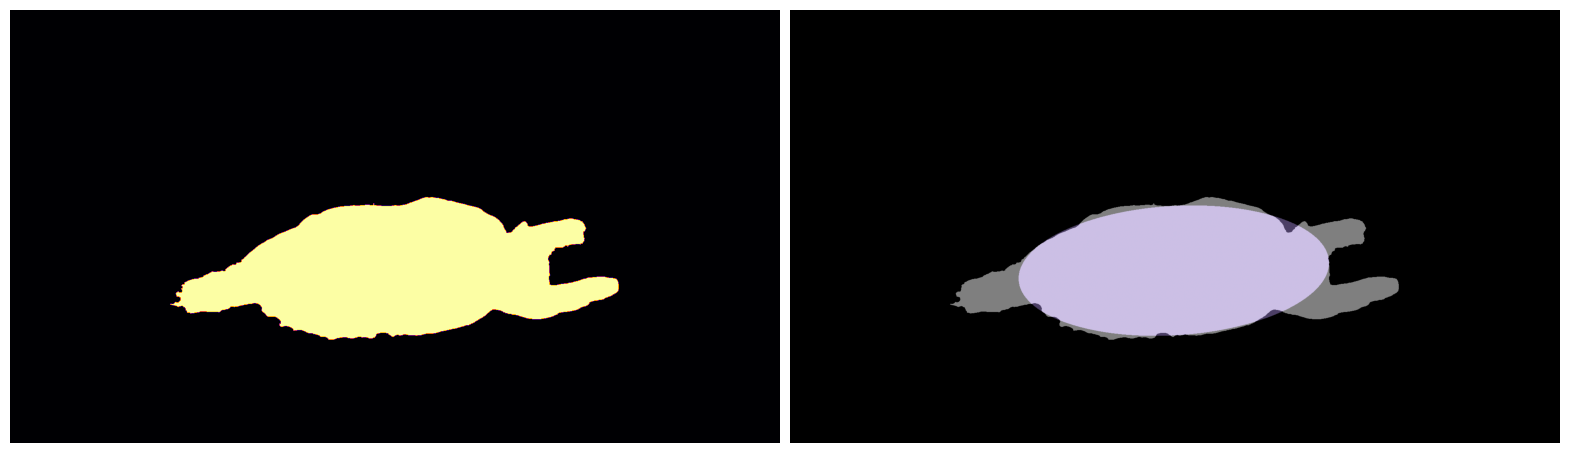

Optimization terminated successfully.
         Current function value: -85530.000000
         Iterations: 123
         Function evaluations: 265


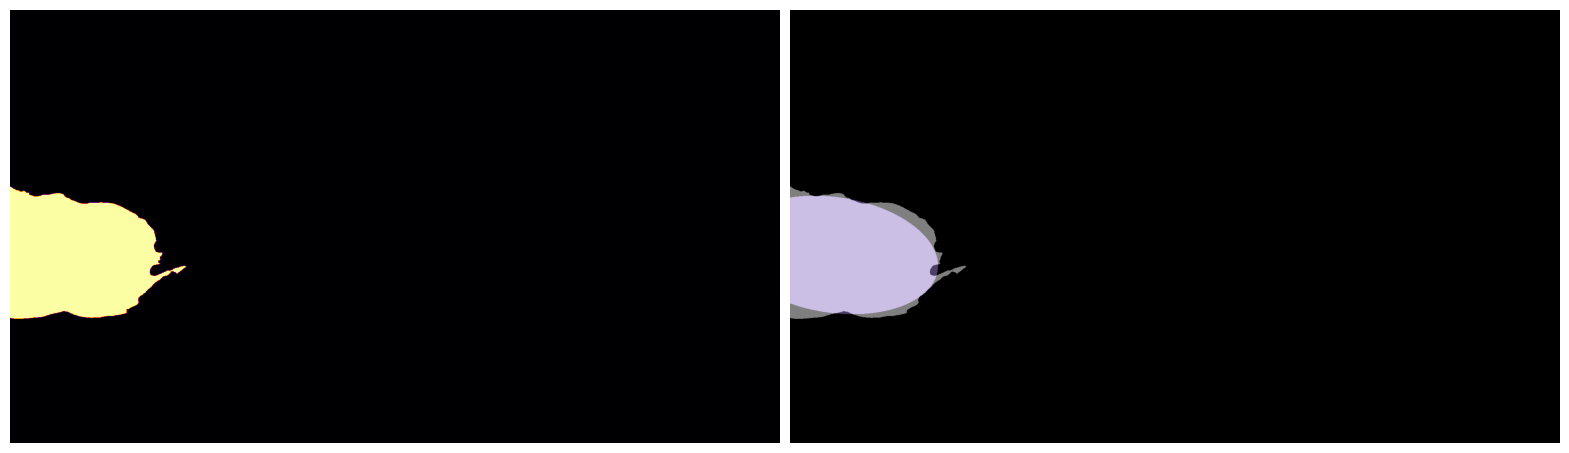

Optimization terminated successfully.
         Current function value: -155812.000000
         Iterations: 123
         Function evaluations: 257


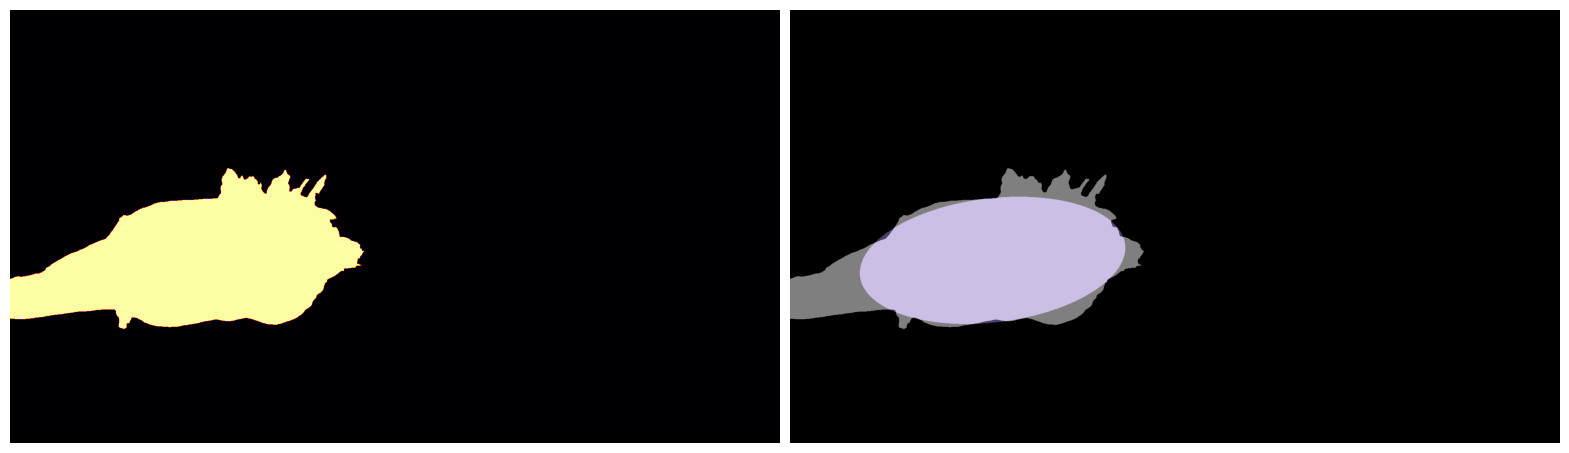

In [56]:
for mask in masks: 
    plot([mask, generate_elipses(mask)], (1, 2))